# Machine Learning Engineer Nanodegree
## Capstone Project
Brian Long  
November 10th, 2019

## I. Definition
<font color="red">_(approx. 1-2 pages)_</font>

### Project Overview
<font color="red">
In this section, look to provide a high-level overview of the project in layman’s terms. Questions to ask yourself when writing this section:
    
- _Has an overview of the project been provided, such as the problem domain, project origin, and related datasets or input data?_
- _Has enough background information been given so that an uninformed reader would understand the problem domain and following problem statement?_
</font>

Twitter is a micro-blogging platform where users can post short messages referred to as
“tweets”. Tweets used to be limited to 140 characters but this limit was increased to 280
characters in 2017. This enforced conciseness made Twitter a popular platform for
people to quickly voice their opinion about a topic without needing to publish a
multi-page article. Millions of people write multiple tweets every day to express their
thoughts or opinions, both formal and informal. Twitter has become a place for friends to
share pictures of their lunch, as well as a place for professionals to discuss emerging
practices and technologies.

The thing that interests me the most about Twitter as a social media platform is the
frequency and openness with which people post. In many ways, a person’s twitter feed
is like a journal of their day to day life. There is a wealth of information that seems
almost purposefully structured for data science. For example, the use of hashtags to
label tweets allows them to be categorized by topic without breaking up the platform into
multiple smaller communities that are defined by that topic. Using the public Twitter API,
developers can access data about tweets that can then be aggregated and used to
drive business decisions across a variety of fields.

Twitter stands out as a tool for sentiment analysis because the text differs heavily from
the usual data that comes from sources such as movie reviews, product reviews, or
news articles. These other sources are typically large bodies of text with proper
grammar, whereas tweets are have a strict character limit which keeps them short while
also having a very informal tone that doesn't follow grammatical convention. Twitter has
been studied as a source of sentiment analysis in the following papers:

Go, A., Bhayani, R. and Huang, L., 2009. Twitter sentiment classification using distant
supervision. CS224N Project Report, Stanford, 1(12).
https://cs.stanford.edu/people/alecmgo/papers/TwitterDistantSupervision09.pdf

Agarwal, A., Xie, B., Vovsha, I., Rambow, O., Passonneau, R., Sentiment Analysis of
Twitter Data. Columbia.
http://www.cs.columbia.edu/~julia/papers/Agarwaletal11.pdf



### Problem Statement
<font color="red">
In this section, you will want to clearly define the problem that you are trying to solve, including the strategy (outline of tasks) you will use to achieve the desired solution. You should also thoroughly discuss what the intended solution will be for this problem. Questions to ask yourself when writing this section:
    
- _Is the problem statement clearly defined? Will the reader understand what you are expecting to solve?_
- _Have you thoroughly discussed how you will attempt to solve the problem?_
- _Is an anticipated solution clearly defined? Will the reader understand what results you are looking for?_
</font>


The information I would most like to extract from these tweets is the general sentiment
in terms of whether it has a positive or negative tone. Sentiment analysis is a popular
problem in the field of Natural Language Processing. The intricacies of language make
it difficult to algorithmically extract meaning from a given body of text. While true
sentiment contains much more complexity than can be expressed by the broad
definitions of having a positive or negative point of view, this is still valuable information
as it can be used to quantify the general public’s feelings towards a company, product,
or idea.

I will be attempting to create a model that can determine whether a tweet expresses a
positive or negative sentiment. This model could eventually be used to build a tool that
uses the Twitter API to have the sentiment evaluated for new tweets. This could further
be used to show trends in how the general public views a given topic and leveraged to
make business decisions.



### Metrics
<font color="red">
In this section, you will need to clearly define the metrics or calculations you will use to measure performance of a model or result in your project. These calculations and metrics should be justified based on the characteristics of the problem and problem domain. Questions to ask yourself when writing this section:
    
- _Are the metrics you’ve chosen to measure the performance of your models clearly discussed and defined?_
- _Have you provided reasonable justification for the metrics chosen based on the problem and solution?_
</font>


The main metric I will be using to measure the benchmark and solution models will be
accuracy. I choose to focus on accuracy over precision or recall because mislabeling a
tweet as positive or negative has the same impact. In this instance we are not
specifically trying to identify all positive tweets or avoid incorrectly labeling a negative
tweet as positive, but to correctly identify as many tweets as possible, regardless of
whether they are positive or negative. Since the target class distribution is perfectly
balanced between positive and negative tweets, using accuracy should not be affected
by simply favoring one choice over the other. I will also be looking at F1-score as a
secondary metric so that precision and recall are not entirely discounted, although my
main focus will be on improving accuracy.




## II. Analysis
<font color="red">_(approx. 2-4 pages)_</font>

### Data Exploration
<font color="red">
In this section, you will be expected to analyze the data you are using for the problem. This data can either be in the form of a dataset (or datasets), input data (or input files), or even an environment. The type of data should be thoroughly described and, if possible, have basic statistics and information presented (such as discussion of input features or defining characteristics about the input or environment). Any abnormalities or interesting qualities about the data that may need to be addressed have been identified (such as features that need to be transformed or the possibility of outliers). Questions to ask yourself when writing this section:
    
- _If a dataset is present for this problem, have you thoroughly discussed certain features about the dataset? Has a data sample been provided to the reader?_
- _If a dataset is present for this problem, are statistics about the dataset calculated and reported? Have any relevant results from this calculation been discussed?_
- _If a dataset is **not** present for this problem, has discussion been made about the input space or input data for your problem?_
- _Are there any abnormalities or characteristics about the input space or dataset that need to be addressed? (categorical variables, missing values, outliers, etc.)_
</font>

I will be using a subset of the Sentiment140 dataset to build my Twitter sentiment analysis model.
This dataset is a collection of 1.6 million tweets that were gathered from the Twitter API
and are labeled as positive or negative. I have cut down the dataset to 700k tweets and added column headers to the csv file included in this project.
Since this dataset was intended for use in sentiment analysis, it was set up such that there is a perfect class balance with exactly
50% of the training data being positive and 50% being negative. The tweets were
labeled based on their inclusion of emoticons, with variations of smiling emoticons being
labeled positive, and variations of frowning emoticons being labeled negative. The
emoticons were also removed from the dataset after the sentiment labels were added.
This dataset was put together using distant supervised learning as a way to showcase
its viability in labeling data this way. The data was tested against Naive Bayes,
Maximum Entropy, and Support Vector Machine models, all of which scored over 80%
accuracy. The complete Sentiment140 dataset is available at the following link:

http://help.sentiment140.com/for-students

Go, A., Bhayani, R. and Huang, L., 2009. Twitter sentiment classification using distant
supervision. CS224N Project Report, Stanford, 1(12).
https://cs.stanford.edu/people/alecmgo/papers/TwitterDistantSupervision09.pdf

Below, I will begin by importing the dataset and viewing a sample of the entries.

The dataset contains 6 columns:
    - sentiment: can be either 0 or 4. 0 represents a negative sentiment and 4 represents a positive sentiment.
    - tweet_id: the id of the tweet from the Twitter API.
    - date: the date that the tweet was posted to Twitter.
    - query: the search term used by to find the tweet.
    - user: the username of the person who posted the tweet.
    - tweet: the content of the tweet that was posted to Twitter.
    
The 'sentiment' column represents the label we will be attempting to predict.

In [1]:
import pandas as pd
import numpy as np

pd.options.display.max_colwidth = 1000
df = pd.read_csv("twitter_data_700k.csv")

In [2]:
df.head()

,sentiment,tweet_id,date,query,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


In the 'sentiment' column above, all of the values appear to be 0, indicating that the sentiment is negative. This is because the data is organized in such that the first half of the dataset is negative and the second half is positive. This can be seen further by examining the tail of the dataset.

In [3]:
df.tail()

,sentiment,tweet_id,date,query,user,tweet
699995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best feeling ever
699996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interviews! ♫ http://blip.fm/~8bmta
699997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me for details
699998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! Tupac Amaru Shakur
699999,4,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity @SpeakingUpH4H


Since the data is organized this way, I will want to shuffle it before training the model. A better representation of the data distribution can be seen by calling sample() on our dataset.  The columns 'tweet_id', 'date', 'query', and 'user' were included in this dataset, but aren't particularly useful in determining the sentiment of the tweet. The 'tweet' column is the only feature I will be focusing on. I dropped the unnecessary features and sample the dataset below.


In [4]:
df.drop(["tweet_id", "date", "query", "user"], axis=1, inplace=True)
df.sample(10)

,sentiment,tweet
528787,4,I'm going for Mac Donald's breakfast now! Envious people?
468704,4,@skitzot I heart Hickory House
28538,0,just woke up ... tryin to get motivated very hard rigth now .... gettin readi to do the hair n eat cant wait ... school tomorow .....
603158,4,Now he aint got shit to say im finna put my pussy all n his face frm all dat shit he beene talkn !
178184,0,of course im almost there and theres traffic
346402,0,@Tattooed_Mummy It's a shame that there is no one inspiring enough not to get the vote based on them Not being the BNP #theBNPareTwats
370558,4,@lesliesinks lmao I know
133851,0,"@chevalierkun I don't know what to say about anime on free TV. It's good, but I hate how it aired with bad subs and changing schedule"
208234,0,I didn't get the trip letter... @riddlingsaulie @purity_of_arms
413081,4,is taking the last step to move on once and for all


As there are only 2 values representing sentiment, I should change that label to be either a 0 or 1 rather than using 4 for the positive sentiment. The tweet content also contains a lot of information that likely won't be useful in determining sentiment, such as usernames and urls. Another challenge will be the informality of speech used. Words are often exaggerated by repeating letters, words are misspelled, and sarcasm is common.

### Exploratory Visualization
<font color="red">
In this section, you will need to provide some form of visualization that summarizes or extracts a relevant characteristic or feature about the data. The visualization should adequately support the data being used. Discuss why this visualization was chosen and how it is relevant. Questions to ask yourself when writing this section:
    
- _Have you visualized a relevant characteristic or feature about the dataset or input data?_
- _Is the visualization thoroughly analyzed and discussed?_
- _If a plot is provided, are the axes, title, and datum clearly defined?_
</font>



The bar graph below shows the perfect class balance of the dataset with the positive and negative tweets each having 350,000 instances.

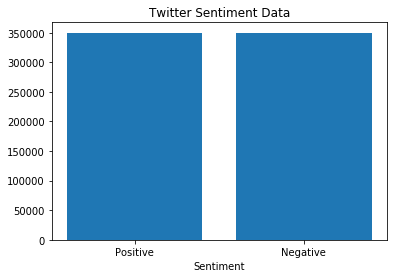

Positive Tweets: 350000
Negative Tweets: 350000


In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

pos = len(df.loc[df["sentiment"] == 4])
neg = len(df.loc[df["sentiment"] == 0])

labels = ["Positive", "Negative"]
values = [pos, neg]

index = np.arange(len(labels))

plt.title("Twitter Sentiment Data")
plt.xlabel("Sentiment")
plt.xticks(index, labels)
plt.bar(index, values)
plt.show()

print(f"Positive Tweets: {pos}")
print(f"Negative Tweets: {neg}")


Below I show the character counts across the tweet data. The original 140 character limit is shown clearly here, with a few instances using a couple more characters which must be after the update to allow 280 characters. It seems to be a somewhat level distribution after about 15 characters, with a large number of tweets being "short and sweet" at around 25-50 characters, followed but a slight dip until a spike in tweets right near the character limit.

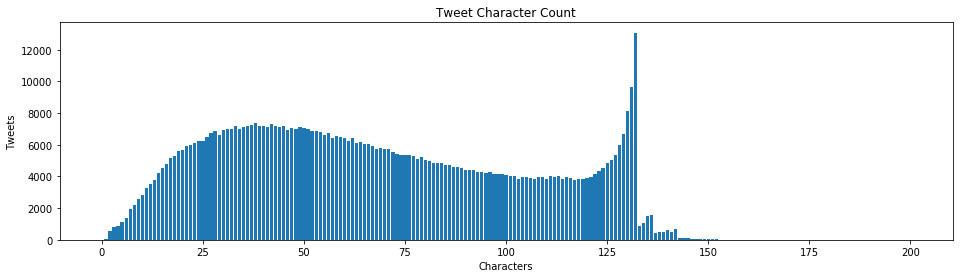

In [52]:
char_count = df["tweet"].apply(lambda x: len(x))
char_dict = char_count.groupby(char_count).count().to_dict()

index = np.arange(len(char_dict))

plt.figure(figsize=(16,4))
plt.title("Tweet Character Count")
plt.xlabel("Characters")
plt.ylabel("Tweets")
plt.bar(index, char_dict.values())
plt.show()


Next, I will look at the word count in these tweets. While this does relate closely to the character count, we get additional information here which can be useful in future steps when we will need to tokenize and pad the tweets to all be the same length. It appears that most tweets contain around 5 to 10 words. The number of tweets then trail off and don't seem to extend beyond 35 words.

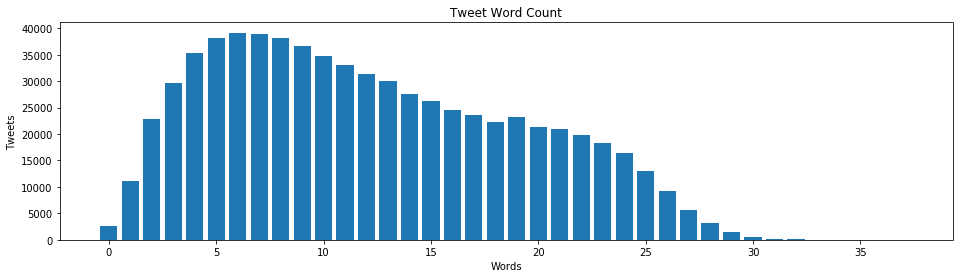

In [53]:
word_count = df["tweet"].apply(lambda x: len(x.split()))
word_dict = char_count.groupby(word_count).count().to_dict()

index = np.arange(len(word_dict))

plt.figure(figsize=(16,4))
plt.title("Tweet Word Count")
plt.xlabel("Words")
plt.ylabel("Tweets")
plt.bar(index, word_dict.values())
plt.show()


### Algorithms and Techniques
<font color="red">
In this section, you will need to discuss the algorithms and techniques you intend to use for solving the problem. You should justify the use of each one based on the characteristics of the problem and the problem domain. Questions to ask yourself when writing this section:
    
- _Are the algorithms you will use, including any default variables/parameters in the project clearly defined?_
- _Are the techniques to be used thoroughly discussed and justified?_
- _Is it made clear how the input data or datasets will be handled by the algorithms and techniques chosen?_
</font>


I intend to use a Recurrent Neural Network (RNN) as a classifier for the sentiment of the tweets. RNN's, and in particular Long Short-Term Memory networks (LSTMs), have gained popularity as a tool for natural language processing tasks because they have the ability to understand a sentence as a sequence of words rather than a random jumbling of words. RNN's do this by maintaining the state of its previous outputs to use as input in the next step. This leads to a sophistication of understanding that other "bag-of-words" models can't achieve. For example, given the text "My team did not win", a bag-of-words model might see the word "win" and predict that the text is positive, where a RNN might notice the negation in "did not win" and be able to predict that the text is negative.

I plan to do some preprocessing on the tweet content to try to normalize the text, as the informal and concise nature of Twitter leads to some very creative spelling and grammar. This will mostly involve removing text that doesn't seem useful in determining the sentiment of the tweet. 

After the text content has gone through preprocessing. I will train an LSTM network on the data using an embedding layer as the input. The embedding layer is used to create word vector representations and is more efficient than using one-hot encoding as they can lead to a huge amount of features that are mostly 0's.


### Benchmark
<font color="red">
In this section, you will need to provide a clearly defined benchmark result or threshold for comparing across performances obtained by your solution. The reasoning behind the benchmark (in the case where it is not an established result) should be discussed. Questions to ask yourself when writing this section:
    
- _Has some result or value been provided that acts as a benchmark for measuring performance?_
- _Is it clear how this result or value was obtained (whether by data or by hypothesis)?_
</font>


I will be using a Naive Bayes model with a Bag of Words approach as my benchmark
model. Naive Bayes is often used as a benchmark in Natural Language Processing
problems since the implementation is simple but fairly effective. This model will then be
tested for accuracy in terms of how many tweets were correctly identified as positive or
negative.

Before testing the benchmark model, I first separate the data into labels and features. The labels will be the sentiment, which I will also run through a mapping function to convert all of the 4's into 1's. The feature set will consist of only the tweet content. I then split the dataset into training and testing subsets using scikit-learn's train_test_split.

In [5]:
from sklearn.model_selection import train_test_split

y = df['sentiment'].map({0: 0, 4: 1}) # here I am mapping the labels to be 0 and 1 rather than 0 and 4
X = df.drop(['sentiment'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)

I will tokenize the tweet content using a CountVectorizer. This will keep track of the number of times each feature/word appears in a given instance. A Naive Bayes model is then fit to the training data before predicting the sentiment class of the test data.

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

count_vector = CountVectorizer()

train_vector = count_vector.fit_transform(X_train['tweet'])
test_vector = count_vector.transform(X_test['tweet'])

In [7]:
from sklearn.naive_bayes import MultinomialNB
naive_bayes = MultinomialNB()
naive_bayes.fit(train_vector, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [8]:
predictions = naive_bayes.predict(test_vector)

In [9]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

[[72530 14882]
 [23765 63823]]
              precision    recall  f1-score   support

           0       0.75      0.83      0.79     87412
           1       0.81      0.73      0.77     87588

   micro avg       0.78      0.78      0.78    175000
   macro avg       0.78      0.78      0.78    175000
weighted avg       0.78      0.78      0.78    175000

0.77916


## III. Methodology
<font color="red">_(approx. 3-5 pages)_</font>

### Data Preprocessing
<font color="red">
In this section, all of your preprocessing steps will need to be clearly documented, if any were necessary. From the previous section, any of the abnormalities or characteristics that you identified about the dataset will be addressed and corrected here. Questions to ask yourself when writing this section:
    
- _If the algorithms chosen require preprocessing steps like feature selection or feature transformations, have they been properly documented?_
- _Based on the **Data Exploration** section, if there were abnormalities or characteristics that needed to be addressed, have they been properly corrected?_
- _If no preprocessing is needed, has it been made clear why?_
</font>

The labels were already altered in the benchmarking step to have positive tweets labeled with a 1 rather than a 4, but the tweet content will still need a good amount of preprocessing due to the informal nature of the tweets. I will apply a series text substitutions using regular expressions to make the tweets a little more uniform and to remove unnecessary information to reduce the dimensionality of the feature set. 

First, all characters will be converted lowercase. Usernames int the format @user and hashtags in the format #tag will be removed as these can often refer to a subject but do not a sentiment. Urls are removed as they may link to relevant information, but don't carry that information in url form. Repeated letters are reduced down to only repeating the letter twice so that words like "hellooooo" and "hellllooooo" would both map to "helloo". While this is not ideal, as they should map to "hello", some repeated letters are valid, such as the "ll" in "hello", so reducing all repeated characters to a single character would have its own problems. Punctuation that is used to break up a thought, such as a comma, period, or exclamation point, is replaced with a space since it is common to forget to add that space and simply removing it could combine the two words around it. Other punctuation, such as an apostrophe, is simply removed to combine the letters in contractions rather than treating them as separate words, for example "don't" will be "dont" instead of "don" and "t". Finally all words with less than 3 characters are removed to get rid of filler words that dont add much to a sentence like "as" or "of". 

This cleans up the tweet content by a significant amount, but the informal speech will still have some issues that are harder to detect and fix such as sarcasm.

In [10]:
import re

def processTweet(tweet):
    tweet = tweet.lower() # lowercase
    tweet = re.sub("[@|#]\w+\S","", tweet) # remove @usernames and #hashtags
    tweet = re.sub("http[s]?://[\S]+", '', tweet) # remove urls 
    tweet = re.sub(r"(.)\1\1+",r"\1\1", tweet) # remove letters that repeat more than 2 times
    tweet = re.sub('[!&()+,-./:;<=>?[\\]_{|}~]', ' ',tweet) # replace certain punctuation with a space 
    tweet = re.sub('[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]', '',tweet) # remove remaining punctuation
    tweet = re.sub(r'\b\w{1,2}\b', '', tweet) # remove words that are less than 3 characters
    return tweet

In [11]:
df['tweet'] = df['tweet'].map(lambda tweet: processTweet(tweet))

df.head()

,sentiment,tweet
0,0,aww thats bummer you shoulda got david carr third day
1,0,upset that cant update his facebook texting and might cry result school today also blah
2,0,dived many times for the ball managed save the rest out bounds
3,0,whole body feels itchy and like its fire
4,0,its not behaving all mad why here because cant see you all over there


### Implementation
<font color="red">
In this section, the process for which metrics, algorithms, and techniques that you implemented for the given data will need to be clearly documented. It should be abundantly clear how the implementation was carried out, and discussion should be made regarding any complications that occurred during this process. Questions to ask yourself when writing this section:
    
- _Is it made clear how the algorithms and techniques were implemented with the given datasets or input data?_
- _Were there any complications with the original metrics or techniques that required changing prior to acquiring a solution?_
- _Was there any part of the coding process (e.g., writing complicated functions) that should be documented?_
</font>



I first run the data through a tokenizer so that the sentences are broken down into sequences. A maximum vocabulary size is used so that less important features are discarded. After the tweets are tokenized, I add padding to the shorter sequences to ensure that they will all be the same length to be fed into the neural network. I decided that the maximum length should be 35 based on the word count graph in the Exploratory Visualization section.

In [12]:
from keras.preprocessing import sequence, text
from keras.utils import to_categorical

from sklearn.feature_extraction.text import TfidfVectorizer

vocabulary_size = 20000

tokenizer = text.Tokenizer(num_words=vocabulary_size)
tokenizer.fit_on_texts(X_train['tweet'])

train_token = tokenizer.texts_to_sequences(X_train['tweet'])
test_token = tokenizer.texts_to_sequences(X_test['tweet'])

max_words = 35
train_padded = sequence.pad_sequences(train_token, maxlen=max_words)
test_padded = sequence.pad_sequences(test_token, maxlen=max_words)

Using TensorFlow backend.


After the input data is prepared, I define the architecture for the neural network. I will use an embedding layer layer as input, with the input dimensions being equal to the vocabulary size. The input length of each sequence will be max_words which is the length of all of the sequences after padding. The output dimension of the embedding layer will be 32, which is a number I found through trial and error. This will then feed into an LSTM layer, which will have a dropout rate of 0.5 to prevent overfitting. The output of the LSTM layer will go into a Fully-Connected layer which will determine the final prediction using a sigmoid activation function. The summary can be seen below.

In [13]:
from keras import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Activation

embedding_size=32

model = Sequential()
model.add(Embedding(vocabulary_size, embedding_size, input_length=max_words))
model.add(LSTM(32, dropout=0.5))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())


W1109 10:22:00.889613 140057212016384 deprecation_wrapper.py:119] From /home/blong/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1109 10:22:00.905909 140057212016384 deprecation_wrapper.py:119] From /home/blong/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1109 10:22:00.908086 140057212016384 deprecation_wrapper.py:119] From /home/blong/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1109 10:22:00.983535 140057212016384 deprecation_wrapper.py:119] From /home/blong/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_w

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 32)            640000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 648,353
Trainable params: 648,353
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
loss_func = 'binary_crossentropy'

model.compile(loss=loss_func, 
             optimizer='adam', 
             metrics=['accuracy'])

W1109 10:22:01.181432 140057212016384 deprecation_wrapper.py:119] From /home/blong/anaconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1109 10:22:01.198382 140057212016384 deprecation_wrapper.py:119] From /home/blong/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W1109 10:22:01.207900 140057212016384 deprecation.py:323] From /home/blong/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Since there are only two classes as output, positive (1) and negative (0), binary crossentropy will be used as the loss function when compiling the model.

When training the model, I will use two callbacks, ModelCheckpoint for saving the best performing model during training, and EarlyStopping to prevent the training from continuing if the model isn't improving anymore. Both the ModelCheckpoint and the EarlyStopper will be using validation accuracy as the metric to monitor. This allows me to set the epochs at a higher number than I expect to be beneficial and allow the model to stop itself when it isn't learning anymore. The data is then shuffled and split into 80% training and 20% validation sets and the model is trained on it.

In [15]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

saved_model_path = 'model.weights.best.hdf5'

checkpointer = ModelCheckpoint(filepath=saved_model_path, 
                               monitor='val_acc',
                               save_best_only=True,
                               verbose=1)

early_stop = EarlyStopping(monitor='val_acc', 
                           patience=3,
                           verbose=1)

batch_size = 32
num_epochs = 20
model.fit(train_padded, 
          y_train, 
          validation_split=0.2, 
          batch_size=batch_size, 
          epochs=num_epochs,
          shuffle=True,
          callbacks=[checkpointer, early_stop])


Train on 420000 samples, validate on 105000 samples
Epoch 1/20
420000/420000 [==============================] - 648s 2ms/step - loss: 0.4498 - acc: 0.7904 - val_loss: 0.4244 - val_acc: 0.8040

Epoch 00001: val_loss improved from inf to 0.42440, saving model to model.weights.best.hdf5
Epoch 2/20
420000/420000 [==============================] - 644s 2ms/step - loss: 0.4019 - acc: 0.8170 - val_loss: 0.4085 - val_acc: 0.8127

Epoch 00002: val_loss improved from 0.42440 to 0.40846, saving model to model.weights.best.hdf5
Epoch 3/20
420000/420000 [==============================] - 647s 2ms/step - loss: 0.3825 - acc: 0.8283 - val_loss: 0.4034 - val_acc: 0.8165

Epoch 00003: val_loss improved from 0.40846 to 0.40342, saving model to model.weights.best.hdf5
Epoch 4/20
420000/420000 [==============================] - 652s 2ms/step - loss: 0.3692 - acc: 0.8353 - val_loss: 0.4044 - val_acc: 0.8169

Epoch 00004: val_loss did not improve from 0.40342
Epoch 5/20
420000/420000 [=======================

After the training has completed, I will load the best weights into the model. Then I will use the model to predict the sentiment of the test data.

In [16]:
model.load_weights(saved_model_path)

In [17]:
rnn_pred = model.predict_classes(test_padded)

In [18]:
print(confusion_matrix(y_test, rnn_pred))
print(classification_report(y_test, rnn_pred))
print(accuracy_score(y_test, rnn_pred))

[[71814 15598]
 [16177 71411]]
              precision    recall  f1-score   support

           0       0.82      0.82      0.82     87412
           1       0.82      0.82      0.82     87588

   micro avg       0.82      0.82      0.82    175000
   macro avg       0.82      0.82      0.82    175000
weighted avg       0.82      0.82      0.82    175000

0.8184285714285714


### Refinement
<font color="red">
In this section, you will need to discuss the process of improvement you made upon the algorithms and techniques you used in your implementation. For example, adjusting parameters for certain models to acquire improved solutions would fall under the refinement category. Your initial and final solutions should be reported, as well as any significant intermediate results as necessary. Questions to ask yourself when writing this section:
    
- _Has an initial solution been found and clearly reported?_
- _Is the process of improvement clearly documented, such as what techniques were used?_
- _Are intermediate and final solutions clearly reported as the process is improved?_
</font>

## IV. Results
<font color="red">_(approx. 2-3 pages)_</font>

### Model Evaluation and Validation
<font color="red">
In this section, the final model and any supporting qualities should be evaluated in detail. It should be clear how the final model was derived and why this model was chosen. In addition, some type of analysis should be used to validate the robustness of this model and its solution, such as manipulating the input data or environment to see how the model’s solution is affected (this is called sensitivity analysis). Questions to ask yourself when writing this section:
    
- _Is the final model reasonable and aligning with solution expectations? Are the final parameters of the model appropriate?_
- _Has the final model been tested with various inputs to evaluate whether the model generalizes well to unseen data?_
- _Is the model robust enough for the problem? Do small perturbations (changes) in training data or the input space greatly affect the results?_
- _Can results found from the model be trusted?_
</font>



### Justification
<font color="red">
In this section, your model’s final solution and its results should be compared to the benchmark you established earlier in the project using some type of statistical analysis. You should also justify whether these results and the solution are significant enough to have solved the problem posed in the project. Questions to ask yourself when writing this section:
    
- _Are the final results found stronger than the benchmark result reported earlier?_
- _Have you thoroughly analyzed and discussed the final solution?_
- _Is the final solution significant enough to have solved the problem?_
</font>



## V. Conclusion
<font color="red">_(approx. 1-2 pages)_</font>

### Free-Form Visualization
<font color="red">
In this section, you will need to provide some form of visualization that emphasizes an important quality about the project. It is much more free-form, but should reasonably support a significant result or characteristic about the problem that you want to discuss. Questions to ask yourself when writing this section:
    
- _Have you visualized a relevant or important quality about the problem, dataset, input data, or results?_
- _Is the visualization thoroughly analyzed and discussed?_
- _If a plot is provided, are the axes, title, and datum clearly defined?_
</font>

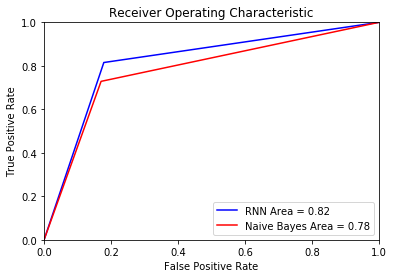

In [26]:
import sklearn.metrics as metrics

naive_fpr, naive_tpr, naive_threshold = metrics.roc_curve(y_test, predictions)
naive_roc_auc = metrics.auc(naive_fpr, naive_tpr)

rnn_fpr, rnn_tpr, rnn_threshold = metrics.roc_curve(y_test, rnn_pred)
rnn_roc_auc = metrics.auc(rnn_fpr, rnn_tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(rnn_fpr, rnn_tpr, 'b', label = 'RNN Area = %0.2f' % rnn_roc_auc)
plt.plot(naive_fpr, naive_tpr, 'r', label = 'Naive Bayes Area = %0.2f' % naive_roc_auc)
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()



### Reflection
<font color="red">
In this section, you will summarize the entire end-to-end problem solution and discuss one or two particular aspects of the project you found interesting or difficult. You are expected to reflect on the project as a whole to show that you have a firm understanding of the entire process employed in your work. Questions to ask yourself when writing this section:
    
- _Have you thoroughly summarized the entire process you used for this project?_
- _Were there any interesting aspects of the project?_
- _Were there any difficult aspects of the project?_
- _Does the final model and solution fit your expectations for the problem, and should it be used in a general setting to solve these types of problems?_
</font>



### Improvement
<font color="red">
In this section, you will need to provide discussion as to how one aspect of the implementation you designed could be improved. As an example, consider ways your implementation can be made more general, and what would need to be modified. You do not need to make this improvement, but the potential solutions resulting from these changes are considered and compared/contrasted to your current solution. Questions to ask yourself when writing this section:
    
- _Are there further improvements that could be made on the algorithms or techniques you used in this project?_
- _Were there algorithms or techniques you researched that you did not know how to implement, but would consider using if you knew how?_
- _If you used your final solution as the new benchmark, do you think an even better solution exists?_
</font>

<font color="red">

-----------
**Before submitting, ask yourself. . .**

- Does the project report you’ve written follow a well-organized structure similar to that of the project template?
- Is each section (particularly **Analysis** and **Methodology**) written in a clear, concise and specific fashion? Are there any ambiguous terms or phrases that need clarification?
- Would the intended audience of your project be able to understand your analysis, methods, and results?
- Have you properly proof-read your project report to assure there are minimal grammatical and spelling mistakes?
- Are all the resources used for this project correctly cited and referenced?
- Is the code that implements your solution easily readable and properly commented?
- Does the code execute without error and produce results similar to those reported?
</font>